In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load CSV File
df = pd.read_csv('/content/drive/MyDrive/Honda_cleaned.csv')
df1 = df.reset_index()['Price']

In [4]:
print(df)
df.describe()

            Date   Price    Open    High     Low     Volume  Change
0       4/1/2018  132870  130830  132870  130200  148900000   32200
1       5/1/2018  134030  133330  135130  133000  143000000    8700
2       9/1/2018  133670  134730  135230  133230  103400000   -2700
3      10/1/2018  136730  134500  138370  134270  140800000   22900
4      11/1/2018  134200  134500  135170  133270  120900000  -18500
...          ...     ...     ...     ...     ...        ...     ...
1447   8/12/2023  145800  148800  149000  145050  286000000  -25700
1448  11/12/2023  149450  149600  150100  148650  148500000   25000
1449  12/12/2023  147750  150100  150200  147750  113200000  -11400
1450  13/12/2023  146900  147650  147700  145600  140800000   -5800
1451  14/12/2023  139550  143400  143950  138900  270400000  -50000

[1452 rows x 7 columns]


,Price,Open,High,Low,Volume,Change
count,1452.000000,1452.000000,1452.000000,1452.000000,1.452000e+03,1452.000000
mean,110568.891185,110612.348485,111570.557851,109594.655647,1.393168e+08,221.831956
std,18352.269684,18428.936931,18496.291126,18256.798866,5.240151e+07,18326.814457
min,71180.000000,71720.000000,74670.000000,70670.000000,3.360000e+07,-71000.000000
25%,99537.500000,99572.500000,100560.000000,98652.500000,1.040000e+08,-10100.000000
50%,108700.000000,108830.000000,109715.000000,107815.000000,1.284000e+08,0.000000
75%,117270.000000,117440.000000,118132.500000,116385.000000,1.624750e+08,10225.000000
max,180230.000000,180230.000000,182100.000000,178000.000000,4.645000e+08,106200.000000


In [5]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [6]:
# Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 49ms/step - loss: 0.0062
Epoch 2/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0015
Epoch 3/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0011
Epoch 4/100
15/15 [==============================] - 1s 51ms/step - loss: 8.8884e-04
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 8.2010e-04
Epoch 6/100
15/15 [==============================] - 1s 56ms/step - loss: 7.9845e-04
Epoch 7/100
15/15 [==============================] - 1s 58ms/step - loss: 7.4615e-04
Epoch 8/100
15/15 [==============================] - 1s 64ms/step - loss: 7.5030e-04
Epoch 9/100
15/15 [==============================] - 1s 59ms/step - loss: 6.9424e-04
Epoch 10/100
15/15 [==============================] - 1s 36ms/step - loss: 6.9661e-04
Epoch 11/100
15/15 [==============================] - 1s 39ms/step - loss: 6.4049e-04
Epoch 12/100
15/15 [==============================] - 1s 39ms/step - loss: 

In [11]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 8ms/step


In [12]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [13]:
# Forecast Next 30 Days
last_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

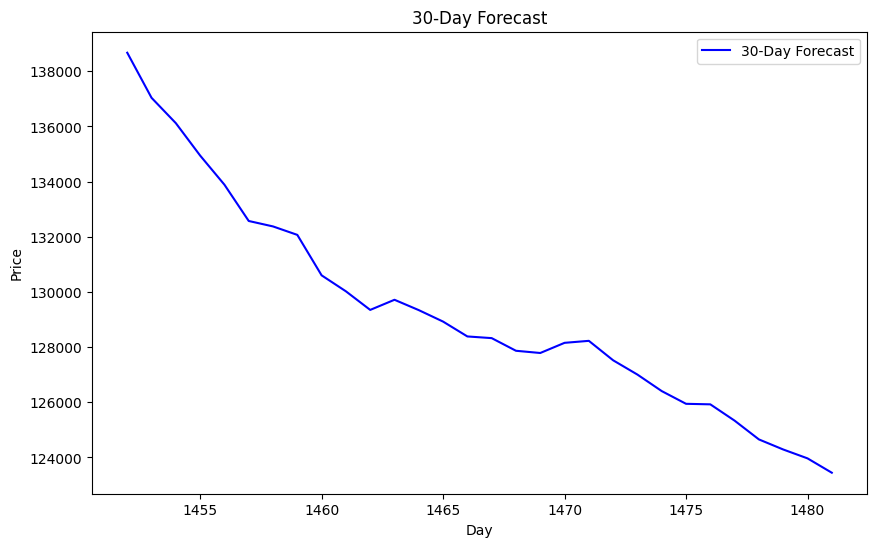

In [14]:
# Assuming 'lst_output' contains your 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)

# Plotting the 30-day forecast
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, color='blue')
plt.title('30-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['30-Day Forecast'])
plt.show()

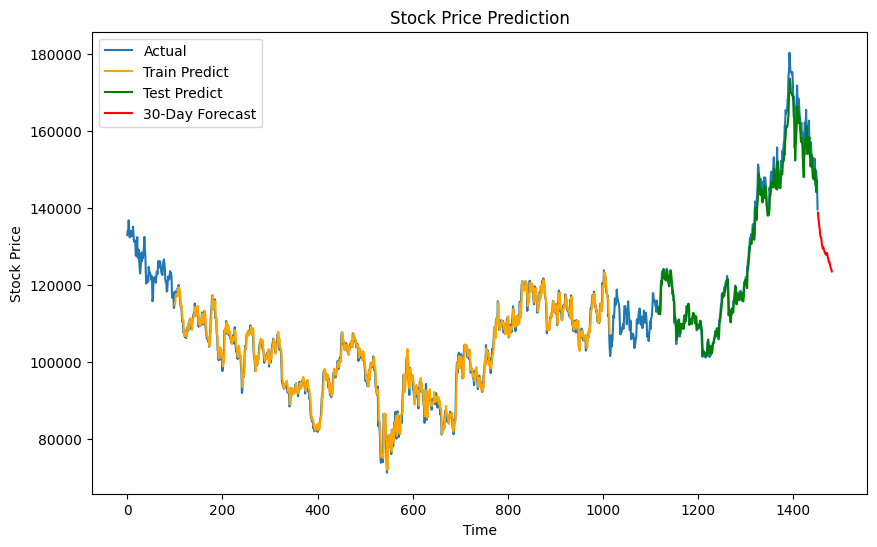

In [15]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))

# Plot entire dataset
plt.plot(scaler.inverse_transform(df1), label='Actual')

# Plot training predictions
train_predict_plot = np.empty_like(df1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Train Predict', color='orange')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Test Predict', color='green')

# Plot 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, label='30-Day Forecast', color='red')

# Adding legends and labels
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

# Compute Huber Loss
delta = 1.0  # You can adjust the delta parameter
test_huber_loss = np.mean(huber_loss(y_test_actual, test_predict, delta))
print('Testing Huber Loss:', test_huber_loss)

Testing RMSE: 2977.532162515165
Testing MAE: 2167.6647854477606
Testing MAPE: 1.5669083007375257
Testing Huber Loss: 2167.16482188666
